# Gaining Early Insights from Textual Data - Exploratory Data Analysis - Using TF-IDF to measure token importance

## Refer to Chapter 1 in the optional textbook

# Introducing the Dataset


In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

In [2]:
pd.options.display.max_colwidth = 150 ###
file = "un-general-debates-blueprint.csv"
df = pd.read_csv(file)
df.sample(2, random_state=53)

,session,year,country,country_name,speaker,position,text
3871,51,1996,PER,Peru,Francisco Tudela Van Breughel Douglas,Minister for Foreign Affairs,"﻿At the outset, allow me,\nSir, to convey to you and to this Assembly the greetings\nand congratulations of the Peruvian people, as well as\ntheir..."
4697,56,2001,GBR,United Kingdom,Jack Straw,Minister for Foreign Affairs,"﻿Please allow me\nwarmly to congratulate you, Sir, on your assumption of\nthe presidency of the fifty-sixth session of the General\nAssembly.\nThi..."


## Tokenization with Regular Expressions


In [3]:
import regex as re

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

## Treating Stop Words


In [4]:
import nltk
# not in book: make sure stop words are available
#nltk.download('stopwords')

In [5]:
stopwords = set(nltk.corpus.stopwords.words('english'))

In [6]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

In [7]:
include_stopwords = {'dear', 'regards', 'must', 'would', 'also'}
exclude_stopwords = {'against'}

stopwords |= include_stopwords
stopwords -= exclude_stopwords

## Processing a Pipeline with one Line of Code


In [8]:
pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [9]:
df['tokens'] = df['text'].progress_apply(prepare, pipeline=pipeline)

100%|██████████| 7507/7507 [00:14<00:00, 516.34it/s]


In [10]:
df['num_tokens'] = df['tokens'].progress_map(len)

100%|██████████| 7507/7507 [00:00<00:00, 974335.94it/s]


In [11]:
df.sample(2, random_state=53)

,session,year,country,country_name,speaker,position,text,tokens,num_tokens
3871,51,1996,PER,Peru,Francisco Tudela Van Breughel Douglas,Minister for Foreign Affairs,"﻿At the outset, allow me,\nSir, to convey to you and to this Assembly the greetings\nand congratulations of the Peruvian people, as well as\ntheir...","[outset, allow, sir, convey, assembly, greetings, congratulations, peruvian, people, well, best, wishes, hopes, future, peru, country, successfull...",765
4697,56,2001,GBR,United Kingdom,Jack Straw,Minister for Foreign Affairs,"﻿Please allow me\nwarmly to congratulate you, Sir, on your assumption of\nthe presidency of the fifty-sixth session of the General\nAssembly.\nThi...","[please, allow, warmly, congratulate, sir, assumption, presidency, fifty-sixth, session, general, assembly, day, november, anniversary, armistice,...",771


In [12]:
from collections import Counter ###
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].progress_map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [13]:
freq_df = count_words(df)
freq_df.head(5)

100%|██████████| 7507/7507 [00:01<00:00, 5113.56it/s]


,freq
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734


In [14]:
# top words with 10+ characters
count_words(df, column='text', preprocess=lambda text: re.findall(r'\w{10,}', text)).head(150)

100%|██████████| 7507/7507 [00:10<00:00, 695.45it/s] 


,freq
token,
international,106974
development,51334
Government,35528
Organization,33763
developing,25177
...,...
provisions,2692
coexistence,2672
establishing,2635


## Blueprint: Ranking with TF-IDF


In [15]:
from collections import Counter


In [16]:
def compute_idf(df, column='tokens', preprocess=None, min_df=2):

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    # count tokens
    counter = Counter()
    df[column].progress_map(update)

    # create data frame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df') #document frequency (df), not dataframe df
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df

In [17]:
idf_df = compute_idf(df)

100%|██████████| 7507/7507 [00:01<00:00, 4998.14it/s]
C:\Users\makub\AppData\Local\Temp\ipykernel_7080\3664387232.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1


In [18]:
# Not in book: sample of IDF values
# high IDF means rare (interesting) term
idf_df.sample(5)

,df,idf
token,,
prejudiced,22,5.932549
cash-,2,8.330444
maw,3,7.924979
finalizing,67,4.818899
statements,853,2.274832


In [19]:
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

In [20]:
# not in book: joining is faster
freq_df = freq_df.join(idf_df)
freq_df['tfidf'] = freq_df['freq'] * freq_df['idf']
freq_df

,freq,tfidf,df,idf
token,,,,
nations,124508,12649.986284,7495.0,0.101600
united,120763,12285.608632,7494.0,0.101733
international,117223,12364.276226,7466.0,0.105477
world,89421,9503.708982,7460.0,0.106281
countries,85734,10888.485986,7307.0,0.127003
...,...,...,...,...
unrewarding,2,16.660888,2.0,8.330444
israel-egypt,2,16.660888,2.0,8.330444
non-jews,2,16.660888,2.0,8.330444


In [21]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

In [22]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

100%|██████████| 193/193 [00:00<00:00, 9641.16it/s]


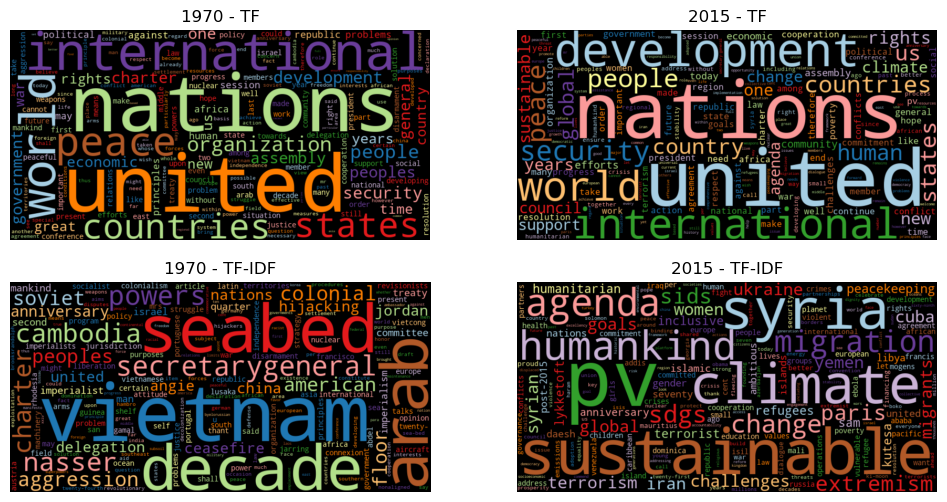

In [23]:
freq_1970 = count_words(df[df['year'] == 1970])
freq_2015 = count_words(df[df['year'] == 2015])

freq_1970['tfidf'] = freq_1970['freq'] * idf_df['idf']
freq_2015['tfidf'] = freq_2015['freq'] * idf_df['idf']

plt.figure(figsize=(12,6)) ###
#wordcloud(freq_df['freq'], title='All years', subplot=(1,3,1))
plt.subplot(2,2,1)###
wordcloud(freq_1970['freq'], title='1970 - TF', 
          stopwords=['twenty-fifth', 'twenty-five'])
plt.subplot(2,2,2)###
wordcloud(freq_2015['freq'], title='2015 - TF', 
          stopwords=['seventieth'])
plt.subplot(2,2,3)###
wordcloud(freq_1970['tfidf'], title='1970 - TF-IDF', 
          stopwords=['twenty-fifth', 'twenty-five', 'twenty', 'fifth'])
plt.subplot(2,2,4)###
wordcloud(freq_2015['tfidf'], title='2015 - TF-IDF', 
          stopwords=['seventieth'])